In [10]:
# @Author: Wenke Xia (wxia1@fandm.edu), Xiaorui Lu (xlu47@ucsc.edu)
# @Date: 2021-07-28 21:44:37 
# @Last Modified by:   Wenke Xia 
# @Last Modified time: 2021-07-28 21:44:37 

In [11]:
import os
import sys
import time
import json
import math
import copy
import random  
import _thread
import numpy as np
import tkinter as tk
import tkinter.font as tf
import tkinter.messagebox
from PIL import Image,ImageTk 
import matplotlib.pyplot as plt
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
if(float(str(sys.version)[0:3]) < 3.8): input("PYTHON VERSION >=3.8 IS REQUIRED."); exit() #检查Python版本>=3.8

In [12]:
start = "2021.07.24 02:00:00"
end = "2021.07.24 11:00:00"
telescope = [31, 121.9, 10] #[Lat., Lon., Hei.] TM Tele.
elev_range = [15, 75] #[min., max.] TM Tele.
compute_range = False
#telescope = [32.701500, -109.891284, 3185] #[Lat., Lon., Hei.] AZ Tele.
#elev_range = [30, 80] #[min., max.] AZ Tele.

psrListFilename = "psr_list.txt"
#psrListFilename = "psr_list_debug.txt"

In [13]:
# 格式化源名的字符串
def getPsrName(array):
    if("3C" in array["source"]):
        return array["source"].replace("'", "").replace('"', "").replace("–", "-")
    if("G" in array["source"]):
        return array["source"].replace("'", "").replace('"', "").replace("–", "-")
    return "PSR" + array["source"].replace("'", "").replace('"', "").replace("–", "-")

# 排序
def sorting_rewrite(array):
    listForSorting = list()
    for i in range(len(array)):
        listForSorting.append([i, array[i]["rises"][0][0]])
        
    listForSorting = sorted(listForSorting, key=lambda x:x[1])
    for i in range(len(listForSorting)):
        listForSorting[i] = array[listForSorting[i][0]]

    return listForSorting

# 时间加减
def hours_plus(time1, time2):
    time0 = time1 + time2
    while(time0 > 24):
        time0 = time0 - 24
    
    return time0

# 生成坐标ticks
def gen_axis(start, hours, gap=2):
    axis = []
    added_hours = 0
    while(hours > added_hours):
        added_hours = added_hours + gap
        axis.append(hours_plus(start, added_hours))
    
    return axis

# 绘制图像
def psr_plot(loadedKey, saveFig = False):
    plt.clf() # 清图。
    plt.cla() # 清坐标轴
    plt.close() # 关窗口
    
    PSRS = list()
    #loadedKey = compute_durs(loadedKey)
    plt.rcParams['figure.figsize'] = (16,8)
    if(len(loadedKey) >= 1):
        x = delta_midnight[math.floor(1000*((loadedKey[0]['dur_started'] - startTimestamp)/(plotLength*60*60)))].value
        plt.axvline(x, 0, 90,color="red")
        plt.scatter(delta_midnight, astropy.coordinates.get_sun(Timestamp(startTimestamp) + delta_midnight).transform_to(altazframe).alt,lw=0,s=500, c='y', alpha=0.01, cmap='coolwarm')
    
    #Route
    for key in range(len(loadedKey)):
        value = loadedKey[key]
        #print(loadedKey[key]["source"])
        star_name = getPsrName(loadedKey[key])
        # print(star_name)
        skyCo = coord(star_name.replace("'", ""))
        transformed = skyCo.transform_to(altazframe)
        PSRS.append(skyCo)
        # print(skyCo)

        plt.scatter(delta_midnight, transformed.alt,lw=0,s=2, c='k', alpha=0.1, cmap='coolwarm')
        #print(transformed.alt[1:3])
        #print(delta_midnight[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))])
        #plt.plot(delta_midnight[value["dur_started"]:value["dur_ended"]],PSR_B0329altazs[value["dur_ended"]:value["dur_ended"]].alt, c='b', label='PSR B0329+54' )

    #Observe
    for key in range(len(loadedKey)):
        value = loadedKey[key]
        #print(loadedKey[key]["source"])
        star_name = getPsrName(loadedKey[key])
        # print(star_name)
        skyCo = coord(star_name.replace("'", ""))
        transformed = skyCo.transform_to(altazframe)
        PSRS.append(skyCo)
        # print(skyCo)
        
        obs_begin = value["dur_started"] - startTimestamp
        obs_end = value["dur_ended"] - startTimestamp

        plt.scatter(delta_midnight[math.floor(1000*(obs_begin/(plotLength*60*60))):math.floor(1000*(obs_end/(plotLength*60*60)))], transformed.alt[math.floor(1000*(obs_begin/(plotLength*60*60))):math.floor(1000*(obs_end/(plotLength*60*60)))], label=star_name,lw=3,s=3)
        plt.text(delta_midnight[math.floor(1000*(obs_begin/(plotLength*60*60)))].value, transformed.alt[math.floor(1000*(obs_begin/(plotLength*60*60)))].value, "* " + getPsrName(value), fontsize=9, alpha=.75)
        #plt.text(1, 2, "111")
        #print(transformed.alt[1:3])
        #print(delta_midnight[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))])
        #plt.plot(delta_midnight[value["dur_started"]:value["dur_ended"]],PSR_B0329altazs[value["dur_ended"]:value["dur_ended"]].alt, c='b', label='PSR B0329+54' )
    
    #Gap
    for key in range(len(loadedKey)):
        value = loadedKey[key]
        #print(loadedKey[key]["source"])
        star_name = getPsrName(loadedKey[key])
        # print(star_name)
        skyCo = coord(star_name.replace("'", ""))
        transformed = skyCo.transform_to(altazframe)
        PSRS.append(skyCo)
        # print(skyCo)
        
        obs_begin = value["dur_started"] - startTimestamp
        obs_end = value["dur_ended"] - startTimestamp
        
        x = delta_midnight[math.floor(1000*((obs_end)/(plotLength*60*60))):math.floor(1000*((obs_end+value["gap"])/(plotLength*60*60)))]
        y = [transformed.alt[math.floor(1000*((obs_end)/(plotLength*60*60)))].value] * len(x)
        plt.scatter(x, y,lw=1,s=1, c='k', alpha=.2)
        plt.axvline(delta_midnight[math.floor(1000*((obs_end+value["gap"])/(plotLength*60*60)))].value, 0, 90,color="black", alpha=.2)
        #plt.scatter(delta_midnight[math.floor(1000*((obs_end-value["gap"])/(plotLength*60*60))):math.floor(1000*((obs_end)/(plotLength*60*60)))], [transformed.alt[math.floor(1000*((obs_end-value["gap"])/(plotLength*60*60)))]],lw=5,s=1, c='w', alpha=.8)
        #print(transformed.alt[1:3])
        #print(delta_midnight[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))])
        #plt.plot(delta_midnight[value["dur_started"]:value["dur_ended"]],PSR_B0329altazs[value["dur_ended"]:value["dur_ended"]].alt, c='b', label='PSR B0329+54' )
    
    plt.axvline(delta_midnight[math.floor(1000*((obs_end)/(plotLength*60*60)))].value, 0, 90,color="red") 
    #plt.axhline(elev_range[0], -3, 3,color="red")
    #plt.axhline(elev_range[1], -3, 3,color="red")
    plt.fill_between(np.arange((plotLength/2)+1)*2, 0, elev_range[0], facecolor='black', alpha=0.1)
    plt.fill_between(np.arange((plotLength/2)+1)*2, elev_range[1], 90, facecolor='black', alpha=0.1)

    if(len(loadedKey) < 25):
        plt.legend(loc=0)
    plt.xlim(0, 0.7*24)
    plt.xticks(np.arange((plotLength/2)+1)*2)
    #plt.xticks(gen_axis(int(abs_start_hours), durations/60/60))
    #print(gen_axis(int(abs_start_hours), durations/60/60))
    plt.ylim(0, 90)
    plt.title("Schedule Preview")
    #plt.grid()
    plt.xlabel('Hours from UTC '+ time.strftime("%Y-%m-%d %H:%M:%S", time.strptime(start, "%Y.%m.%d %H:%M:%S")))
    plt.ylabel('Altitude [deg]')
    
    if(saveFig):
        plt.savefig(getTempPath('scheduller.jpg'), transparent=False)
        return getTempPath('scheduller.jpg')
    else:
        plt.show()
    
    return True

# 格式化生成缓存目录Path
def getTempPath(filename, path = "__scheduller"):
    if(os.path.exists(path) == False):
        os.mkdir(path)
    
    return path + "/" + filename

# 从Sched .key文件加载
def psr_load(keyin_file, compute_gap = False):
    rawKey = ""
    obs_started = "%Y.%m.%d %H:%M:%S"
    
    # Open file    
    fileHandler  =  open  (keyin_file,  "r")
    # Get list of all lines in file
    listOfLines  =  fileHandler.readlines()
    # Close file
    fileHandler.close()
                           
    for  line in  listOfLines:
        # Get next line from file
        # If line is empty then end of file reached
        line = line.strip()
        
        if not line :
            break;
        thisLineRaw = line.strip()
        
        if("source" in thisLineRaw):
            rawKey = rawKey + "\n" + thisLineRaw
        
        if("year" in thisLineRaw):
            obs_started = obs_started.replace("%Y", thisLineRaw.replace(" ", "").replace("year=", ""))
            
        if("month" in thisLineRaw):
            obs_started = obs_started.replace("%m", thisLineRaw.replace(" ", "").replace("month=", ""))
            
        if("day" in thisLineRaw):
            obs_started = obs_started.replace("%d", thisLineRaw.replace(" ", "").replace("day=", ""))
            
        if("start" in thisLineRaw):
            obs_started = obs_started.replace("%H:%M:%S", thisLineRaw.replace(" ", "").replace("start=", ""))
            
        # Close Close    
    fileHandler.close()
    
    keyin_file = keyin_file + ".temp"
    open(keyin_file, "w+").write(rawKey)
    
    try:
        obs_started = time.mktime(time.strptime(obs_started, "%Y.%m.%d %H:%M:%S"))
    except Exception as e:
        obs_started = startTimestamp
        print("[psr_load] Notice: ", str(e), " due to syntax error in the .KEY file. Default setiing will be used, which may cause the plotting error.")
    abs_start_hours = (time.strftime("%H", time.strptime(start, "%Y.%m.%d %H:%M:%S")))
    matrix_raw = np.loadtxt(open(keyin_file,"r"),delimiter=None, dtype=str, converters=None, skiprows=0)  
    shape_raw = matrix_raw.shape
    
    num_vars = ["dur", "gap"]
    keyLocats =[[0, 2], [3, 5], [6, 8], [9, 11]]
    loadedKey = list()
    for a in range(shape_raw[0]):
        #loadedKey[a] = dict()
        loadedKey.append(dict())
        for keyLoc in keyLocats:
            if(matrix_raw[a, keyLoc[0]] in num_vars):
                loadedKey[a][matrix_raw[a, keyLoc[0]]] = int(matrix_raw[a, keyLoc[1]])
            else:
                loadedKey[a][matrix_raw[a, keyLoc[0]]] = matrix_raw[a, keyLoc[1]]
    
    os.remove(keyin_file)
    
    # 修复bug：sched的Gap是指上一个到这一个的gap，脚本里的gap是指这一个到下一个的gap
    for i in range(len(loadedKey)):
        if(i < (len(loadedKey) - 1)):
            loadedKey[i]["gap"] = loadedKey[i+1]["gap"]
    loadedKey[len(loadedKey) - 1]["gap"] = 0
    
    if(compute_gap):
        for i in range(len(loadedKey)):
            if(i >= 1):
                loadedKey[i-1]["gap"] = gap_between(loadedKey[i-1], loadedKey[i])
            loadedKey[i]["gap"] = 0
    
    #nowTime = obs_started
    #for i in range(len(loadedKey)):
    #    loadedKey[i]['dur_started'] = nowTime
    #    
    #    nowTime = nowTime + int(loadedKey[i]['dur']) + int(loadedKey[i]['gap'])
    #    
    #    loadedKey[i]['dur_ended'] = nowTime
                    
    return loadedKey

# 绘制SkyMap
def plotSkyMap(loadedkey, saveFig = False):
    plt.clf() # 清图。
    plt.cla() # 清坐标轴
    plt.close() # 关窗口
    
    RAs = list()
    Decs = list()
    IDs = list()
    Times = list()
    
    for i in range(len(loadedkey)):
        thisKey = loadedkey[i]
        if(i <= 0):
            obs_begin = thisKey['dur_started']
        
        thisCoord = coord(getPsrName(thisKey), False).transform_to(AltAz(obstime=Timestamp(thisKey['dur_started']), location=shanghai)).to_string().split(" ")
        RAs.append(float(thisCoord[0]))
        Decs.append(float(thisCoord[1]))
        IDs.append(getPsrName(thisKey))
        Times.append(thisKey['dur_started'])
        #plt.text(thisCoord[0], thisCoord[1], getPsrName(thisKey))
        #plt.scatter(thisCoord[0], thisCoord[1], c='red', s=100, marker='_', linewidth=1, label=getPsrName(thisKey))
    
    plt.figure(figsize=(16, 16))
    #plt.scatter(RAs, Decs)
    
    plt.plot(RAs,Decs, "ob-",linewidth=1, alpha=0.3)
    for i in range(len(RAs)):
        plt.text(RAs[i], Decs[i], IDs[i])
        plt.text(RAs[i], Decs[i] - 1, displayTime(Times[i] - obs_begin))
        
    sunLoc = [list(), list(), list()]
    sunLoc_ = skyMapSunLoc(Times)
    for i in range(len(sunLoc_[0])):
        if((max(RAs) >= float(sunLoc_[0][i]) and min(RAs) <= float(sunLoc_[0][i])) and (max(Decs) >= float(sunLoc_[1][i]) and min(Decs) <= float(sunLoc_[1][i]))):
            sunLoc[0].append(sunLoc_[0][i])
            sunLoc[1].append(sunLoc_[1][i])
            sunLoc[2].append(sunLoc_[2][i])
        
    plt.plot(sunLoc[0], sunLoc[1], "or-", linewidth=1, alpha=0.3)
    for i in range(len(sunLoc[2])):
        thisTime = sunLoc[2][i]
        plt.text(sunLoc[0][i], sunLoc[1][i], "Sun " + displayTime(thisTime - obs_begin))
        
    #plt.xlim(0, 90)
    #plt.ylim(0, 90)
    plt.xticks(range(int(min(RAs)), int(max(RAs)) + 10, 10), range(int(min(RAs)), int(max(RAs)) + 10, 10))
    plt.yticks(range(0, 91, 10), range(0, 91, 10))
    plt.xlabel("Az. [deg]")
    plt.ylabel("Alt. [deg]")
    plt.title("Schedule Preview (Sky Map)")
    #plt.legend(loc='best')
    
    if(saveFig):
        plt.savefig(getTempPath('scheduller.jpg'), transparent=False)
        return getTempPath('scheduller.jpg')
    else:
        plt.show()

# 为SkyMap计算太阳位置
def skyMapSunLoc(timestamps):
    timestamps_ = list()
    for i in range(len(timestamps)):
        if(i >= 1):
            timestamps_.append(timestamps[i-1] + 1*((timestamps[i] - timestamps[i-1])/3))
            timestamps_.append(timestamps[i-1] + 3*((timestamps[i] - timestamps[i-1])/3))
            timestamps_.append(timestamps[i])
        
    timeList = list()
    sunListRA = list()
    sunListDec = list()

    for thisTime in timestamps_:
        Loc = astropy.coordinates.get_sun(Timestamp(thisTime)).transform_to(AltAz(obstime=Timestamp(thisTime), location=shanghai)).to_string().split(" ")
        timeList.append(thisTime)
        sunListRA.append(float(Loc[0]))
        sunListDec.append(float(Loc[1]))
        
    return [sunListRA, sunListDec, timeList]

# 支持注释的JSON加载
def loadJson(filename):
    rawJson = ""
    fileHandler = open(filename, "r")
    while  True:
        # Get next line from file
        line = fileHandler.readline()
        # If line is empty then end of file reached
        if not line :
            break;
        thisLineRaw = line.strip()
        
        thisLine = ""
        for thisChar in thisLineRaw:
            if(thisChar == "#"): # 支持JSON中的注释
                break
            thisLine = thisLine + thisChar
        rawJson = rawJson + "\n" + thisLine
        # Close Close    
    fileHandler.close()
    
    return json.loads(rawJson)

# 在命令行中运行（支持"python xxxxx.py xxxx.txt"输入文件及参数）
def runOnCmd():
    global psrListFilename
    global compute_range
    
    psrListFilename = sys.argv[1]
    if(if_in_list(sys.argv, 2) and if_in_list(sys.argv, 3)):
        compute_range = [int(sys.argv[2]), int(sys.argv[3])]
    
    return True

# 从JSON中加载配置
def loadConfigFromJson(psrListFile):
    rawJson = loadJson(psrListFile)
    
    global start
    global end
    global telescope
    global elev_range
    global escape_sun
    
    start = rawJson["obs_start"]
    end = rawJson["obs_end"]
    telescope = rawJson["tele_loc"]
    elev_range = rawJson["elev_range"]
    escape_sun =rawJson["escape_sun"]

# 从JSON加载源
def psr_load_list(psrListFilename=False):
    psrList = list()
    psrListRaw = loadJson(psrListFilename)['sources']
    for thisPsr in psrListRaw:
        thisListFormatted = {"source": thisPsr['identifier'], "dur": thisPsr['dur'], "gap": 0, "setup": "", "weight": 1, "force": 0}
        if("weight" in thisPsr):
            thisListFormatted['weight'] = thisPsr['weight']
        if("force" in thisPsr):
            thisListFormatted['force'] = thisPsr['force']
        psrList.append(thisListFormatted)
    
    return psrList

# 计算dur_started & dur_ended
def compute_durs(importedKey):
    durations = startTimestamp
    for a in range(len(importedKey)):
        #loadedKey[a] = dict()
        importedKey[a]["dur_started"] = durations
        #durations = durations + int(importedKey[a]['dur']) + int(importedKey[a]['gap'])
        durations = durations + int(importedKey[a]['dur'])
        importedKey[a]["dur_ended"] = durations
        durations = durations + int(importedKey[a]['gap'])
    return importedKey

# 计算两个源之间的Gap，velocity为[望远镜RA方向的旋转速度, DEC方向的旋转速度]，单位为deg.
def gap_between(key1, key2, velocity = [.5, .6]):
    key1_coord = coord(getPsrName(key1), True)
    key2_coord = coord(getPsrName(key2), True)
    dCoord = [abs(key1_coord[0] - key2_coord[0]), abs(key1_coord[1] - key2_coord[1])]
    tCoord = [dCoord[0]/velocity[0], dCoord[1]/velocity[1]]
    # print(tCoord)
    return max(tCoord)

# 将时间戳转换为Astropy Time Object
def Timestamp(timestamp):
    return Time(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

# 计算升起时间
def riseTime(psrName, location, begin, end, gap = 900):
    lastAlt = -1
    rised = -1
    rises = list()
    nearSun = False
    nearSunList = list()
    for i in range(int((end-begin)/gap)):
        thisAlt = float(coord(psrName).transform_to(AltAz(obstime=Timestamp(begin), location=shanghai)).to_string().split(" ")[1])
        
        if((lastAlt < elev_range[0] and thisAlt > elev_range[0])):
            rised = begin
        elif(lastAlt > elev_range[1] and thisAlt < elev_range[1]):
            rised = begin
        elif((lastAlt < elev_range[1] and thisAlt > elev_range[1])):
            rises.append([rised, begin])
            rised = -1
        elif(lastAlt > elev_range[0] and thisAlt < elev_range[0]):
            rises.append([rised, begin])
            rised = -1
        
        if(deg_to_sun(psrName, Timestamp(begin)) <= escape_sun):
            nearSun = begin
        else:
            if(nearSun != False):
                nearSunList.append([nearSun, begin])
                
                nearSun = False
            
        begin = begin + gap
        lastAlt = thisAlt
    
    if(rised != -1):
        rises.append([rised, begin])
    
    if(len(rises) <= 0):
        rises.append([end+1, end+1])
    
    if(nearSun != False):
        nearSunList.append([nearSun, begin])
    
    return [rises, nearSunList]

# 计算升起时间（改动版本，有问题暂未使用）
def riseTime_rewrite(psrName, location, begin, end, gap = 900):
    lastAlt = -1
    rised = -1
    rises = list()
    nearSun = False
    nearSunList = list()
    frames = int((end - begin) / gap)
    thisTimes = midnight + np.linspace(0, plotLength, frames)*u.hour
    AltAzFrameForThisPsr = coord(psrName).transform_to(AltAz(obstime=thisTimes, location=shanghai)).to_string()
    
    for i in range(frames):
        thisAlt = float(AltAzFrameForThisPsr[i].split(" ")[1])
        
        if((lastAlt < elev_range[0] and thisAlt > elev_range[0])):
            rised = begin
        elif(lastAlt > elev_range[1] and thisAlt < elev_range[1]):
            rised = begin
        elif((lastAlt < elev_range[1] and thisAlt > elev_range[1])):
            rises.append([rised, begin])
            rised = -1
        elif(lastAlt > elev_range[0] and thisAlt < elev_range[0]):
            rises.append([rised, begin])
            rised = -1
        
        if(deg_to_sun(psrName, Timestamp(begin)) <= escape_sun):
            nearSun = begin
        else:
            if(nearSun != False):
                nearSunList.append([nearSun, begin])
                
                nearSun = False
            
        begin = begin + gap
        lastAlt = thisAlt
    
    if(rised != -1):
        rises.append([rised, begin])
    
    if(len(rises) <= 0):
        rises.append([end+1, end+1])
    
    if(nearSun != False):
        nearSunList.append([nearSun, begin])
    
    return [rises, nearSunList]

# 寻找最短升起时间的源
def shortest_rise(array):
    shortest = False
    shortestlen = -1
    for i in range(len(array)):
        thisRiseLen = 0
        for a in range(len(array[i]["rises"])):
            thisRiseLen = thisRiseLen + array[i]["rises"][a][1] - array[i]["rises"][a][0]
        thisRiseLen = thisRiseLen/array[i]['weight']
            
        if(thisRiseLen < shortest or thisRiseLen == -1):
            shortest = i
            shortestlen = thisRiseLen
    
    return shortest

# 寻找force=1的源
def force_list(array):
    theList = list()
    listForSorting = list()
    for i in range(len(array)):
        if(array[i]['force'] == 1):
            theList.append(array[i])
            #listForSorting.append([len(theList)-1, array[i]['weight']])
            listForSorting.append([i, array[i]['weight']])
    
    #listForSorting = sorted(listForSorting, key=lambda x:x[1])
    #for i in range(len(listForSorting)):
    #    listForSorting[i] = theList[listForSorting[i][0]]
    
    return listForSorting

# 以源与源距离最近排序
def nearest_sorting(importedKey, first = False):
    newList = list()
    impList = copy.deepcopy(importedKey)
    
    if(first == False):
        first = smallestRA(impList)
        
    newList = [impList[first]]
    del impList[first]
    while(len(impList) > 0):
        nextPsr = nearest(impList, len(impList)-1)
        newList.append(impList[nextPsr])
        del impList[nextPsr]
    
    return newList

# 寻找下一个距离最近的源
def nearest(importedKey, k, farest = False):
    lastRA = -1
    lastDec = -1
    distKey = list()
    star_name = getPsrName(importedKey[k])
    skyCo = coord(star_name.replace("'", ""))
    sourceRA = float(skyCo.to_string().split(" ")[0])
    sourceDec = float(skyCo.to_string().split(" ")[1])
    
    testKey = [list(), list()]
    nearestKey = [0, False]
    for i in range(len(importedKey)):
        if(i != k):
            star_name = getPsrName(importedKey[i])
            skyCo = coord(star_name.replace("'", ""))
            thisRA = float(skyCo.to_string().split(" ")[0])
            thisDec = float(skyCo.to_string().split(" ")[1])
            #print("w=", importedKey[i]["weight"])
            dDist = (math.sqrt(abs(thisRA - sourceRA)**2 + abs((thisDec - sourceDec))**2))
            #print("d", dDist)
            dDist = dDist/(importedKey[i]["weight"])
            #print("d w/ w", dDist)
            
            if(nearestKey[0] > dDist or nearestKey[1] == False):
                nearestKey = [dDist, i]
                testKey[0].append(thisRA)
                testKey[1].append(thisDec)
    
    if(farest):
        nearestKey = [0, False]
        for i in range(len(importedKey)):
            if(i != k):
                star_name = getPsrName(importedKey[i])
                skyCo = coord(star_name.replace("'", ""))
                thisRA = float(skyCo.to_string().split(" ")[0])
                thisDec = float(skyCo.to_string().split(" ")[1])
                dDist = math.sqrt(abs(thisRA - sourceRA)**2 + abs((thisDec - sourceDec))**2)
                dDist = dDist/(importedKey[i]["weight"]**2)

                if(nearestKey[0] < dDist or nearestKey[1] == False):
                    nearestKey = [dDist, i]
        
        return nearestKey[1]
    
    return nearestKey[1]

# 以RA从小到大排序
def sortedbyRA(importedKey, listi = False):
    listForSorting = list()
    for i in range(len(importedKey)):
        star_name = getPsrName(importedKey[i])
        skyCo = coord(star_name.replace("'", ""))
        thisRA = float(skyCo.to_string().split(" ")[0])
        thisDec = float(skyCo.to_string().split(" ")[1])
        
        listForSorting.append([i, thisRA])
    
    sortedList = list()
    listForSorting = sorted(listForSorting, key=lambda x:x[1])
    if(listi):
        return listForSorting
    
    for i in range(len(listForSorting)):
        sortedList.append(importedKey[listForSorting[i][0]])
    
    return sortedList

# 寻找RA最小的源
def smallestRA(importedKey):
    return sortedbyRA(importedKey, True)[0][0]
        
# 预览
def previewKey(importedKey):
    psr_plot(importedKey)
    #print(importedKey)
    #for i in range(len(importedKey)):
    #    print(importedKey[i]['source'])
    print("##########################\n## EXPORTED KEY PREVIEW ##\n##########################")
    print(saveAsKeyinFile(importedKey))

# 保存为Sched .key文件
def saveAsKeyinFile(importedKey, filename = False):
    keyinFile = ""
    sourceList = ""
    for i in range(len(importedKey)):
        thisGap = "0" # 这一段修复Sched文件Gap是指前一颗源到这一颗源的Gap，而不是这一颗到下一颗的bug。
        if(i >= 1):
            thisGap = str(int(importedKey[i-1]['gap']))
            
        if(i == 0):
            keyinFile = keyinFile + "year=" + time.strftime("%Y", time.localtime(importedKey[i]['dur_started'])) + "\n"
            keyinFile = keyinFile + "month=" + time.strftime("%m", time.localtime(importedKey[i]['dur_started'])) + "\n"
            keyinFile = keyinFile + "day=" + time.strftime("%d", time.localtime(importedKey[i]['dur_started'])) + "\n"
            keyinFile = keyinFile + "start=" + time.strftime("%H:%M:%S", time.localtime(importedKey[i]['dur_started'])) + "\n"
            
        thisCoord = coord(importedKey[i]['source']).to_string("hmsdms").replace("h", ":").replace("m", ":").replace("d", ":").replace("s", "").split(" ")
        keyinFile = keyinFile + "source = "+importedKey[i]['source']+"		dur = "+str(importedKey[i]['dur'])+"	gap = "+thisGap+" setup = 'pfb20cm2'	/" + "\n" 
        sourceList = sourceList + "SOURCE = '" + importedKey[i]['source'] + "'\n        RA=" + thisCoord[0] + "   DEC=" + thisCoord[1] + "     EQUINOX='J2000' CALCODE='V'  /\n"
        
    if(filename != False):
        open(filename, "w+").write(keyinFile)
        open(filename + "_sources.txt", "w+").write(sourceList)
        
    return keyinFile

# 脚本最后一部分中获取命令
def get_cmd(indicator="scheduller 2.1.3"):
    cmd = input("[" + indicator + "] > ").split(" ")
    cmd_dict = dict()
    
    for i in range(len(cmd)):
        cmd_dict[i] = cmd[i]
    
    return cmd_dict

# 元素是否存在Dict/List中
def if_in_list(theList, key):
    theList_dict = dict()
    for i in range(len(theList)):
        theList_dict[i] = theList[i]
    
    if(key in theList_dict):
        return True
    
    return False

def monitoring_txt(filename):
    auto = False
    while(1):
        psr_plot(compute_durs(psr_load(filename)))
        
        if(auto):
            time.sleep(1)
        else:
            cmd = get_cmd("EDITING "+filename)[0]
            if(cmd == "exit"):
                break
            elif(cmd == "auto"):
                auto = True

# 打分
def scoring(importedPossibility, obsLength):
    thisScore = 0
        
    ## 基于时间的利用率
    durations = 0
    for thisKey in importedPossibility['key']:
        durations = durations + thisKey['dur']
    thisScore = thisScore + ((durations)/obsLength)*10

    ## 基于转动时长（gap）打分
    gap_len = 0.0000000001
    for thisKey in importedPossibility['key']:
        gap_len = gap_len + thisKey['gap']
    thisScore = thisScore + (1/gap_len)*10
    
    return thisScore

# 源是否能被观测
def if_observable(start, end, array, step=1800):
    star_name = getPsrName(array)
    observable = True
    
    rises = array['rises']
    rise_obs = False
    for rise in rises:
        if(rise[0] <= start and rise[1] >= end):
            rise_obs = True
    if(rise_obs != True):
        observable = False
        
    suns = array['suns']
    suns_obs = True
    for sun in suns:
        if(start < sun[0] or end > sun[1]):
            suns_obs = False
    if(suns_obs == False):
        observable = False
    
    #nowTime = start
    #while(nowTime < end):
    #    elevation = float(coord(star_name).transform_to(AltAz(obstime=Timestamp(nowTime), location=shanghai)).to_string().split(" ")[1])
    #    if(elevation < 15 and elevation > 75):
    #        observable = False
    #        
    #    nowTime = nowTime + step
    
    return observable

# 获取源坐标RA/DEC
def coord(psrName, retList = False):
    if(findSource(psrName.replace("PSR", "").replace(" ", "")) != False):
        skyCo = SkyCoord(findSource(psrName.replace("PSR", "").replace(" ", "")), frame="icrs", unit=(u.hourangle, u.deg),)
    else:
        print("\r[NOTICE@coord]", psrName, "is not specified in the SourceDB. Trying to solve on SIMBAD and INTERNET REQUIRED.")
        skyCo = SkyCoord.from_name(psrName)
        
        skyCoStrForList = SkyCoord.from_name(psrName).to_string("hmsdms").replace("h", ":").replace("m", ":").replace("d", ":").replace("s", "").split(" ")
        appendSourceDB({"IDENTIFIER": [psrName.replace("PSR", "").replace(" ", "")], "RA": skyCoStrForList[0], "DEC": skyCoStrForList[1]})
    
    if(retList == False):
        return skyCo
    
    skyCo_str = skyCo.to_string().split(" ")
    skyCo_str[0] = float(skyCo_str[0])
    skyCo_str[1] = float(skyCo_str[1])
    
    return skyCo_str

# 距太阳角度
def deg_to_sun(source, time, rtnList = False):
    degSun = astropy.coordinates.get_sun(time).transform_to(AltAz(obstime=time, location=shanghai)).to_string("decimal").split(" ")
    degSrc = coord(source, False).transform_to(AltAz(obstime=time, location=shanghai)).to_string().split(" ")
    degSun[0] = float(degSun[0])
    degSun[1] = float(degSun[1])
    degSrc[0] = float(degSrc[0])
    degSrc[1] = float(degSrc[1])
    
    if(rtnList):
        return [abs(float(degSun[0]) - degSrc[0]), abs(float(degSun[1]) - degSrc[1])]
    else:
        return math.sqrt(abs(float(degSun[0]) - degSrc[0])**2 + abs(float(degSun[1]) - degSrc[1])**2)
    
# 加载源坐标数据
def loadSourceDB(filename):
    if(False == os.path.isfile(filename)):
        open(filename, "w+").write("[]")
        
    return json.loads(open(filename).read())

# 从数据库寻找源
sources_temp = list() # 缓存sources列表，加快脚本运行速度
def findSource(srcName, listType=False, db_file="sources.db"):
    global sources_temp
    
    # 检索缓存列表
    for thisSource in sources_temp:
        if(srcName in thisSource['IDENTIFIER']):
            if(listType):
                return [thisSource['RA'], thisSource['DEC']]
            else:
                return thisSource['RA'] + " " + thisSource['DEC']
    
    # 检索数据库
    for thisSource in loadSourceDB(db_file):
        if(srcName in thisSource['IDENTIFIER']):
            sources_temp.append(thisSource)
            if(listType):
                return [thisSource['RA'], thisSource['DEC']]
            else:
                return thisSource['RA'] + " " + thisSource['DEC']
    
    return False

# 源坐标数据库添加新数据
def appendSourceDB(sourceInfo, filename="sources.db"):
    if(("RA" in sourceInfo) and ("DEC" in sourceInfo) and ("IDENTIFIER" in sourceInfo)):
        loadedDB = loadSourceDB(filename)
        loadedDB.append(sourceInfo)
        
        if(False == os.path.exists('./db_file_backup/') ):
            os.mkdir('./db_file_backup/')
        open('./db_file_backup/'+str(time.time())+'.db', "w+").write(open(filename).read())
        open(filename, "w+").write(json.dumps(loadedDB, indent=4))
        
        return True
    
    return False

# 显示时间
def displayTime(timeInSec):
    if(timeInSec < 60):
        return str(round(timeInSec, 2)) + " sec."
    elif(timeInSec < 3600):
        return str(round(timeInSec/60, 1)) + " min."
    else:
        return str(round(timeInSec/60/60, 1)) + " hr."

# 显示配置
def displayConfig():
    print("=================== CONFIGURATION SUMMARY ===================")
    print("CONFIGURATION FILE", psrListFilename)
    print("OBSERVATION STARTS", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(startTimestamp)))
    print("OBSERVATION ENDS  ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(endTimestamp)))
    print("TELESCOPE LOCATION", telescope, "[Lat., Lon., Hei.]")
    print("RANGE OF ELEVATION", elev_range, "[Deg., Deg.]")
    print("MIN. DEGREE TO SUN", escape_sun, "Deg.")
    print("NUMBER OF SOURCES ", len(psrList))
    print("SEGMENTATION MODE ", compute_range)
    print("=============================================================\n")

# 生成进度条
lastProgress = [[0, 0], [-1, -1, -1]]
def progressBar(i, a, length=15):
    global lastProgress
    
    strBar = ""
    percentage = int((i/a)*100)
    barLength = int((length/a)*i)
    for i in range(length):
        if(i <= barLength):
            strBar = strBar + "#"
        else:
            strBar = strBar + " "
    
    speed = (((percentage - lastProgress[0][0])/((time.time() - lastProgress[0][1])))+10**(-10))
    if(lastProgress[1][0] == -1):
        lastProgress[1] = [speed]*3
    lastProgress[1].append(speed)
    del lastProgress[1][0]
    speed = (lastProgress[1][0] + lastProgress[1][1] + lastProgress[1][2])/3
    
    estTime = (100-percentage)/speed
    lastProgress[0] = [percentage, time.time()]
    return str(percentage) + "%" + "[" + strBar + "] (" + displayTime(estTime) + " rem.)"
            
#print(if_observable(0, 100000, psrList[0]))

#sortedbyRA(loadedKey)
#smallestRA(loadedKey)
#riseTime("PSR J1809-1943", shanghai, startTimestamp, endTimestamp, gap = 599)
#sortedbyRA(psr_load(keyin_file), True)
#findSource("B0823+26")
#print(findSource("B0823+26"))
#print(findSource("B0823+26")[0] + " " + findSource("B0823+26")[1])
#print(SkyCoord(findSource("J1809-1943"), frame="icrs", unit=(u.hourangle, u.deg),))
#print(findSource("J1809-1943"))
#print(SkyCoord.from_name("PSRJ1809-1943").to_string("hmsdms").replace("h", ":").replace("m", ":").replace("d", ":").replace("s", ""))
#force_list(psrList)

In [15]:
#runOnCmd()
print("\rInitializing...", end="")
loadConfigFromJson(psrListFilename)
startTimestamp = time.mktime(time.strptime(start, "%Y.%m.%d %H:%M:%S"))
endTimestamp = time.mktime(time.strptime(end, "%Y.%m.%d %H:%M:%S"))
plotLength = int(endTimestamp - startTimestamp)/60/60 + 1
psrList = psr_load_list(psrListFilename)
shanghai = EarthLocation(lat=telescope[0]*u.deg, lon=telescope[1]*u.deg, height=telescope[2]*u.m)
midnight = Time(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(startTimestamp)), scale='utc')
delta_midnight = np.linspace(0, plotLength, 1000)*u.hour
times = midnight + delta_midnight
altazframe = AltAz(obstime=times, location=shanghai)
listLen = len(psrList)
print("\rInitializing... Done", end="")
print("\r")
displayConfig()

startTime = time.time()
#print(psrList)
for i in range(len(psrList)):
    psrName = (getPsrName(psrList[i])).replace("'", "")
    print("\r" + progressBar(i+1, len(psrList)) + " > [PREPROCESSING " + str(i+1) + "/" + str(len(psrList)) + "]" + psrName, end="")
    riseTimeList = riseTime(psrName, shanghai, startTimestamp, endTimestamp)
    #riseTimeList = riseTime_rewrite(psrName, shanghai, startTimestamp, endTimestamp)
    psrList[i]['rises'] = riseTimeList[0]
    psrList[i]['suns'] = riseTimeList[1]

endTime = time.time()
print(displayTime(endTime - startTime))
print("\rPreprocessing... Done", end="")
print("\r")

#print(psrList)
#优化：删除不升起的源
print("\rOptimizing...", end="")
i = listLen - 1
while(i >= 0):
    #print("\r" + progressBar(i+1, len(psrList)) + " > [OPTIMIZING " + str(i+1) + "/" + str(listLen) + "]" + psrName, end="")
    if(len(psrList[i]['rises']) <= 0):
        del psrList[i]
    i = i - 1
    
print("\rOptimizing... Done", end="")
print("\r")
#print(psrList)

Initializing... Done
=================== CONFIGURATION SUMMARY ===================
CONFIGURATION FILE psr_list.txt
OBSERVATION STARTS 2021-08-01 06:00:00
OBSERVATION ENDS   2021-08-02 06:00:00
TELESCOPE LOCATION [31, 121.9, 10] [Lat., Lon., Hei.]
RANGE OF ELEVATION [15, 75] [Deg., Deg.]
MIN. DEGREE TO SUN 10 Deg.
NUMBER OF SOURCES  79
SEGMENTATION MODE  False

100%[###############] (0.0 sec. rem.) > [PREPROCESSING 79/79]PSRJ2321+602422.9 min.

Preprocessing... Done
Optimizing... Done


In [23]:
if(compute_range == False):
    compute_range_ = range(len(psrList))
else:
    compute_range_ = range(compute_range[0] - 1, compute_range[1], 1)

possibilities = list()
for i in compute_range_:
    print("\r" + progressBar(i+1, len(psrList)) + " > [SORTING " + str(i+1) + "/" + str(len(psrList)) + "] Start \w " + psrList[i]['source'], end="")
    loadedKey = nearest_sorting(psrList, i)
    #loadedKey = sortedbyRA(loadedKey)
    #loadedKey = nearest_sorting(loadedKey)

    search_gap = 600
    nowTime = startTimestamp
    procedKey = copy.deepcopy(sorting_rewrite(loadedKey))
    sortedKey = list()
    lastSearchGap = 0
    thisGap = 0
    while(nowTime < endTimestamp):
        if(len(procedKey) <= 0):
            break
        
        thisSched = False

        for i in range(len(procedKey)):
            thisprocedKey = procedKey[i]
            thisDur = float(thisprocedKey['dur'])
            
            thisGap = 0
            if(len(sortedKey) >= 1):
                thisGap = gap_between(sortedKey[len(sortedKey) - 1], thisprocedKey)
            
            if(if_observable(nowTime + thisGap, nowTime + thisGap + thisDur, thisprocedKey)):
                #print(thisprocedKey["source"])
                #sortedKey.append(thisprocedKey)
                #nowTime = nowTime + thisDur
                #del procedKey[i]
                thisSched = [i, thisDur]
                #print(procedKey)
                break
            
        shortestRisekeyi = shortest_rise(procedKey)
        thisGap = 0
        if(len(sortedKey) >= 1):
            thisGap = gap_between(sortedKey[len(sortedKey) - 1], procedKey[shortestRisekeyi])
        if(if_observable(nowTime + thisGap, nowTime + thisGap + float(procedKey[shortestRisekeyi]['dur']), procedKey[shortestRisekeyi])):
            #print(procedKey[shortestRisekeyi]["source"])
            #sortedKey.append(procedKey[shortestRisekeyi])
            #nowTime = nowTime + thisDur
            #del procedKey[shortestRisekeyi]
            if(thisSched != False):
                thisGap = 0
                if(len(sortedKey) >= 1):
                    thisGap = gap_between(procedKey[thisSched[0]], procedKey[shortestRisekeyi])
                    
                if(if_observable(nowTime + thisSched[1] + thisGap, nowTime + thisGap + thisSched[1] + float(procedKey[shortestRisekeyi]['dur']), procedKey[shortestRisekeyi]) == False):
                    thisSched = [shortestRisekeyi, float(procedKey[shortestRisekeyi]['dur'])]
            else:
                thisSched = [shortestRisekeyi, float(procedKey[shortestRisekeyi]['dur'])]
            #print(procedKey)
        
        forces = force_list(procedKey)
        for thisForce in forces:
            forSourcei = thisForce[0]
            thisGap = 0
            if(len(sortedKey) >= 1):
                thisGap = gap_between(sortedKey[len(sortedKey) - 1], procedKey[forSourcei])
            if(if_observable(nowTime + thisGap, nowTime + thisGap + float(procedKey[forSourcei]['dur']), procedKey[forSourcei])):
                if(thisSched != False):
                    thisGap = 0
                    if(len(sortedKey) >= 1):
                        thisGap = gap_between(procedKey[thisSched[0]], procedKey[forSourcei])
                        
                    if(if_observable(nowTime + thisGap + thisSched[1], nowTime + thisGap + thisSched[1] + float(procedKey[forSourcei]['dur']), procedKey[forSourcei]) == False):
                        thisSched = [forSourcei, float(procedKey[forSourcei]['dur'])]
                        break
                else:
                    thisSched = [forSourcei, float(procedKey[forSourcei]['dur'])]
                    break

        if(thisSched == False):
            nowTime = nowTime + search_gap #如果这次循环没有匹配到可观测的源就把时间往后
            if(len(sortedKey) >= 1):
                lastSearchGap = lastSearchGap + search_gap
        else:
            if(len(sortedKey) >= 1):
                #sortedKey[len(sortedKey) - 2]["gap"] = gap_between(sortedKey[len(sortedKey) - 2], sortedKey[len(sortedKey) - 1]) + lastSearchGap
                #sortedKey[len(sortedKey) - 2]["dur_ended"] = sortedKey[len(sortedKey) - 2]["dur_ended"] +  sortedKey[len(sortedKey) - 2]["gap"]
                thisGap = gap_between(procedKey[thisSched[0]], sortedKey[len(sortedKey) - 1])
                nowTime = nowTime + thisGap
                
            sortedKey.append(procedKey[thisSched[0]])
            sortedKey[len(sortedKey) - 1]['dur_started'] = nowTime
            nowTime = nowTime + thisSched[1]
            sortedKey[len(sortedKey) - 1]['dur_ended'] = nowTime
            del procedKey[thisSched[0]]
            
            lastSearchGap = 0
            
    possibilities.append({"key": sortedKey, "scheduled": sortedKey, "non_scheduled": procedKey})
    
    scheduled = ""
    for a in sortedKey:
        scheduled = scheduled + " " + a['source']
    #print("scheduled: ", scheduled)
    
    non_scheduled = ""
    for a in procedKey:
        non_scheduled = non_scheduled + " " + a['source']
    #print("non-scheduled: ", non_scheduled)
    #print()
    
    #修正gap不正确的问题
    for i in range(len(sortedKey)):
        if(i >= 1):
            sortedKey[i-1]['gap'] = sortedKey[i]['dur_started'] - sortedKey[i-1]['dur_ended']

print("\r\nSorting... Done", end="")
print("\r\n")

100%[###############] (0.0 sec. rem.) > [SORTING 79/79] Start \w J2321+60240
Sorting... Done



Plotting the optimal schedule...
# 0 Previewing [ Key 39 ]
Score: 9.300389384982388
Scheduled  41 out of 79


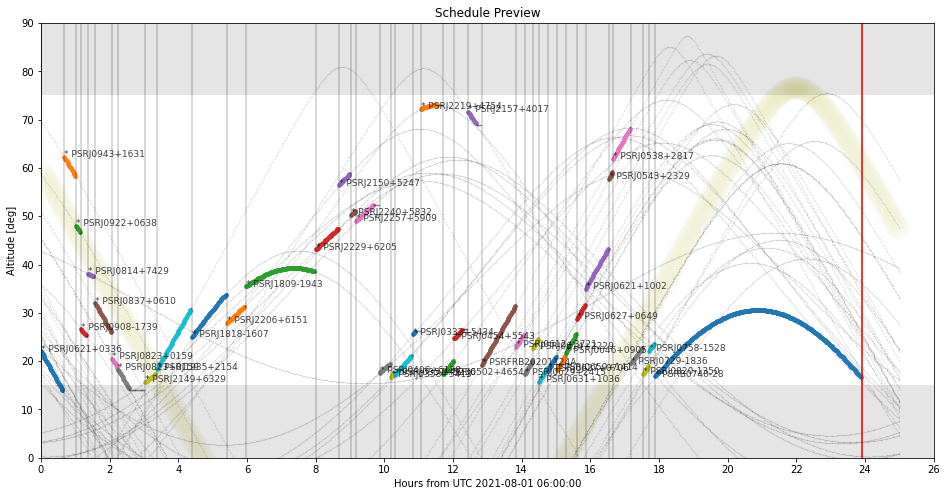

##########################
## EXPORTED KEY PREVIEW ##
##########################
year=2021
month=08
day=01
start=06:00:00
source = J0621+0336		dur = 2400	gap = 0 setup = 'pfb20cm2'	/
source = J0943+1631		dur = 1200	gap = 101 setup = 'pfb20cm2'	/
source = J0922+0638		dur = 480	gap = 16 setup = 'pfb20cm2'	/
source = J0908-1739		dur = 600	gap = 40 setup = 'pfb20cm2'	/
source = J0814+7429		dur = 600	gap = 153 setup = 'pfb20cm2'	/
source = J0837+0610		dur = 1800	gap = 113 setup = 'pfb20cm2'	/
source = J0823+0159		dur = 600	gap = 6 setup = 'pfb20cm2'	/
source = J0823+0159		dur = 1200	gap = 0 setup = 'pfb20cm2'	/
source = J2149+6329		dur = 1200	gap = 1603 setup = 'pfb20cm2'	/
source = J1935+2154		dur = 3600	gap = 69 setup = 'pfb20cm2'	/
source = J1818-1607		dur = 3600	gap = 63 setup = 'pfb20cm2'	/
source = J2206+6151		dur = 1800	gap = 129 setup = 'pfb20cm2'	/
source = J1809-1943		dur = 7200	gap = 135 setup = 'pfb20cm2'	/
source = J2229+6205		dur = 2400	gap = 136 setup = 'pfb20cm2'	/
source = 

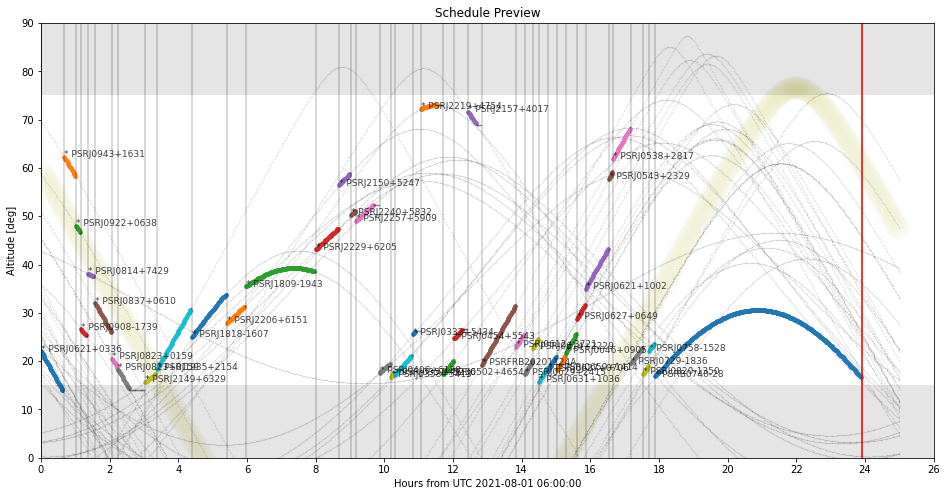

In [26]:
# 寻最佳纲要
scores = list()
for i in range(len(possibilities)):
    possibilities[i]['score'] = scoring(possibilities[i], endTimestamp - startTimestamp)
    scores.append([possibilities[i]['score'], i])
scores = sorted(scores, key=lambda x:x[0], reverse=True)

print("\rPlotting the optimal schedule...")
keyPreviewing = list()
for i in range(1):
    if(len(possibilities[scores[i][1]]['scheduled']) <= 0):
        print("[Warning] No valid schedule found.")
        print("=> Script Exit.")
        input()
        os._exit(0)
        
    print("#", i, "Previewing [ Key", scores[i][1], "]")
    print("Score:", scores[i][0])
    print("Scheduled ", len(possibilities[scores[i][1]]['scheduled']), "out of", listLen)
    #print("Scheduled ", possibilities[scores[i][1]]['scheduled'])
    #print("Non-scheduled ", possibilities[scores[i][1]]['non_scheduled'])
    previewKey(possibilities[scores[i][1]]['key'])
    keyPreviewing = possibilities[scores[i][1]]
    psr_plot(possibilities[scores[i][1]]['key'], True)

print("\rPlotting the optimal schedule... Done", end="")
print("\r\n")

In [27]:
##########################
# SCHEDULLER GUI CLASSES #
##########################

class SchedullerEditor():
    def __init__(self, filename):
        try:
            self.filename = filename
            self.getKeyFile()
            self.keyText = open(self.filename).read()
            self.onTop = 0
            self.window = tk.Tk()

            self.window.title('Scheduller - Editor: ' + filename)
            self.window.geometry('800x500')  # 这里的乘是小x
            self.window.wm_attributes('-topmost', self.onTop)

            ### Begin Menu ###
            menubar = tk.Menu(self.window)  # 创建菜单栏

            file_menu = tk.Menu(menubar, tearoff=False) # 创建空菜单
            file_menu.add_command(label="Save", command=self.save)
            file_menu.add_command(label="Save & Plot", command=self.saveAndPlot)
            file_menu.add_command(label="Save & Show Sky Map", command=self.skyMap)
            file_menu.add_command(label="Save & Compute Gaps", command=self.computeGaps)
            file_menu.add_command(label="Reload", command=self.refresh)
            menubar.add_cascade(label="File", menu=file_menu) # 将file_menu菜单添加到菜单栏

            file_menu = tk.Menu(menubar, tearoff=False) # 创建空菜单
            file_menu.add_command(label="Always on top", command=self.alwaysOnTop)
            menubar.add_cascade(label="Window", menu=file_menu) # 将file_menu菜单添加到菜单栏

            self.window.config(menu=menubar) # display the menu
            ### End Menu ###

            tk.Label(self.window,text="[ Copy: Ctrl/Cmd+C | Paste: Ctrl/Cmd+V | Save&Plot: Ctrl/Cmd+S ]",font=15).pack(expand="yes", anchor="n")
            self.editarea = tk.Text(self.window,width='800',height='500', font=tf.Font(size=9), autoseparators=False)
            self.editarea.pack(expand="yes", anchor="n")
            #self.editarea.tag_add("highlight", "1.0", "1.0")
            self.loadFile()


            self.window.bind("<Control-s>", self.saveAndPlot)
            self.window.bind("<Command-s>", self.saveAndPlot)
            self.window.bind("<Control-g>", self.computeGaps)
            self.window.bind("<Command-g>", self.computeGaps)
            self.window.bind("<Control-p>", self.skyMap)
            self.window.bind("<Command-p>", self.skyMap)
            self.window.bind("<Control-Up>", self.lineGoesUp)
            self.window.bind("<Command-Up>", self.lineGoesUp)
            self.window.bind("<Control-Down>", self.lineGoesDown)
            self.window.bind("<Command-Down>", self.lineGoesDown)

            self.window.protocol("WM_DELETE_WINDOW", self.onClosing)
            self.saveAndPlot()
            
        except Exception as e:
            try:
                self.onClosing()
            except Exception as e:
                pass
            
            print("[Editor] Failed (", str(e), ").")
    
    def skyMap(self, char=""):
        self.save()
        self.log('Plotting "' + self.filename + '".')
        try:
            self.figure = plotSkyMap(compute_durs(psr_load(self.filename, False)), True)
        except Exception as e:
            self.log("Error: Failed to compile key file. This may due to syntax errors while editing.")
            self.log("       " + str(e))
        
        self.showFig((1080, 1080))
        
        return True
    
    def getKeyFile(self):
        keyText = []
        f = open(self.filename, "r",encoding='utf-8')
        line = f.readline() # 读取第一行
        while line:
            keyText.append(line) # 列表增加
            line = f.readline() # 读取下一行

        self.keyText = keyText
    
    def onClosing(self):
        self.top.destroy()
        self.gap.destroy()
        self.window.destroy()

    def lineGoesUp(self, char=""):
        markPos = self.editarea.index('insert')
        to_ = int(markPos.split(".")[0])
        from_ = to_ + 1
        line = self.keyText[from_ - 1]
        
        del self.keyText[from_ - 1]
        self.keyText.insert(to_ - 1, line)
        self.loadFile(False)
        
        self.editarea.mark_set("insert", markPos)
        
        return True
    
    def lineGoesDown(self, char=""):
        markPos = self.editarea.index('insert')
        to_ = int(markPos.split(".")[0])
        from_ = to_ - 1
        line = self.keyText[from_ - 1]
        
        del self.keyText[from_ - 1]
        self.keyText.insert(to_ - 1, line)
        self.loadFile(False)
        
        self.editarea.mark_set("insert", markPos)
        
        return True
    
    def exit(self): #关闭两个窗口
        self.top.destroy()
        self.gap.destroy()
        self.window.destroy()
    
    def refresh(self, warning = True):
        onTop = False
        if(self.onTop == 1):
            self.alwaysOnTop()
            onTop = True
        
        if(warning):
            result = tk.messagebox.askokcancel(title = 'Warning',message='Information you’ve edited may not be saved. \n Are you sure you want to refresh?')
        else:
            result = True
            
        if(onTop):
            self.alwaysOnTop()
            
        if(result):
            self.loadFile()
        
        return True
    
    def loadFile(self, reload = True):
        if(reload):
            self.getKeyFile()
        self.editarea.delete(1.0, tk.END)
        for thisLine in self.keyText: 
            self.editarea.insert(tk.INSERT, thisLine)
        
        return True
    
    def alwaysOnTop(self):
        if(self.onTop == 0):
            self.onTop = 1
        else:
            self.onTop = 0
            
        self.window.wm_attributes('-topmost', self.onTop)

        return True
    
    def saveAndPlot(self, char=""):
        self.save()
        self.log('Plotting "' + self.filename + '".')
        try:
            self.figure = psr_plot(compute_durs(psr_load(self.filename, False)), True)
        except Exception as e:
            self.log("Error: Failed to compile key file. This may due to syntax errors while editing.")
            self.log("       " + str(e))
        
        self.showFig()
        
        return True
    
    def showFig(self, resize = False):
        self.top = tk.Toplevel()
        self.top.title('Scheduller - Figure')
        photo = Image.open(self.figure)
        
        if(resize != False):
            photo = photo.resize(resize)
        img=ImageTk.PhotoImage(photo)
        
        imLabel=tk.Label(self.top,image=img).pack()
        self.top.mainloop()
    
    def RunClicked(self):
        print(1)
    
    def log(self, text):
        print("[Editor]", text)
        
        return True
    
    def refreshGaps(self, char=""):
        self.log('Saved as "' + self.filename + '".')
        open(self.filename, "w+").write(self.editarea.get('1.0', tk.END))
        try:
            loadedKey = psr_load(self.filename)
            saveAsKeyinFile(psr_load(self.filename, True), self.filename)
        except Exception as e:
            self.log("Error: Failed to compile key file. This may due to syntax errors while editing.")
            self.log("       " + str(e))
        self.loadFile()
        self.log('Saved as "' + self.filename + '".')
        self.log('Gap refreshed.')
        
        return True
    
    def computeGaps(self, char=""):
        self.log('Saved as "' + self.filename + '".')
        open(self.filename, "w+").write(self.editarea.get('1.0', tk.END))
        
        try:
            loadedKey = psr_load(self.filename)
        except Exception as e:
            self.log("Error: Failed to compile key file. This may due to syntax errors while editing.")
            self.log("       " + str(e))
            
        strGaps = "===== GAPS COMPUTATION BEGIN =====\n"
        for i in range(len(loadedKey)):
            if(i >= 1):
                strGaps = strGaps + "Gap " + loadedKey[i-1]['source'] + " -> " + loadedKey[i]['source'] + ": " + str(gap_between(loadedKey[i-1], loadedKey[i])) + "\n"
        strGaps = strGaps + "===== GAPS COMPUTATION END ====="
        
        print(strGaps)
        self.showGaps(strGaps)
        
        return True
    
    def showGaps(self, strGaps):
        self.gap = tk.Toplevel()
        self.gap.geometry('350x500')
        self.gap.title('Scheduller - Gaps Computation')
        
        self.showGap = tk.Text(self.gap,width='300',height='300', font=tf.Font(size=9), autoseparators=False)
        self.showGap.pack(expand="yes", anchor="n")
        self.showGap.delete(1.0, tk.END)
        self.showGap.insert(tk.INSERT, strGaps)
        
        self.top.mainloop()
        
    def save(self, char=""):
        self.log('Saved as "' + self.filename + '".')
        open(self.filename, "w+").write(self.editarea.get('1.0', tk.END))
        return True
        

[scheduller 2.1.3] > show skymao
Unknown variable skymao
[scheduller 2.1.3] > show skymap


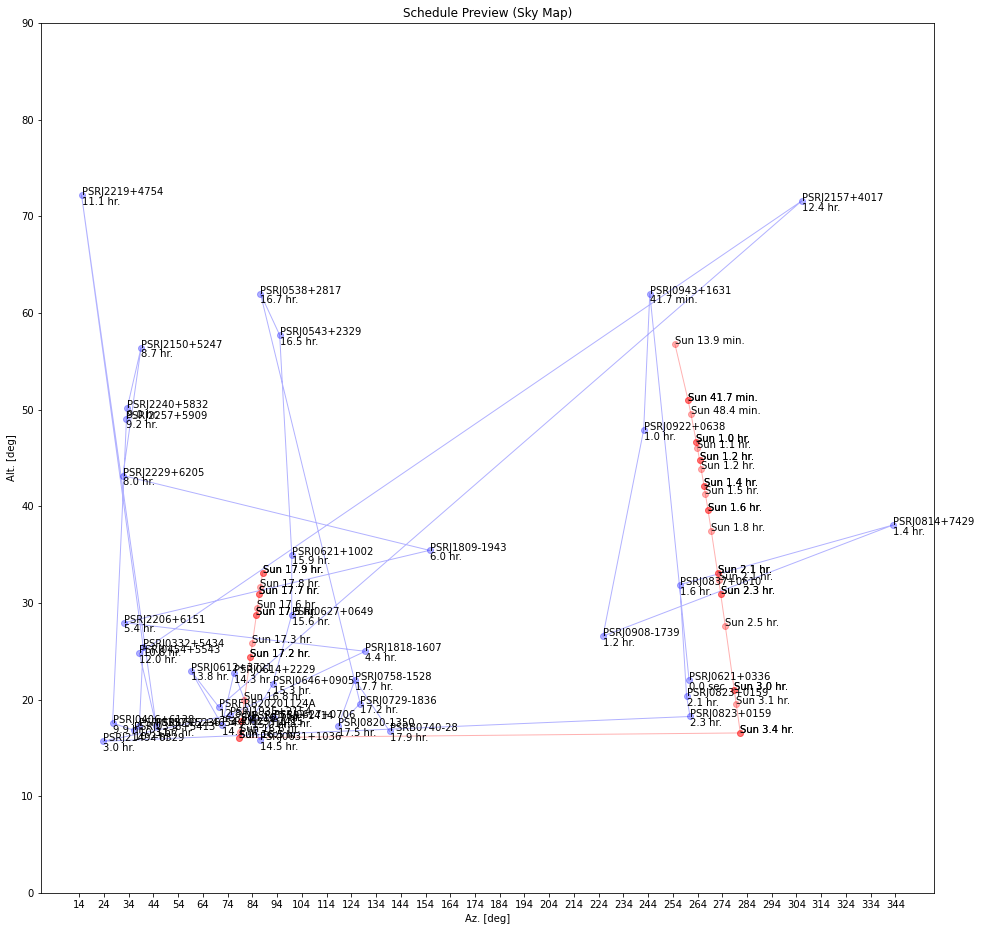

Plotting...
[scheduller 2.1.3] > exit


In [28]:
while(1):
    try:
        cmd = get_cmd()
        
        for i in range(len(cmd)):
            cmd[i] = cmd[i].lower()
            
        if(cmd[0] == "save"):
            if(1 in cmd):
                if(cmd[1] == "sched" or cmd[1] == ".key"):
                    if(2 in cmd):
                        savedName = cmd[2]
                        saveAsKeyinFile(keyPreviewing['key'], savedName)
                        print("Saved as <" + savedName + ">.")
                        print("Coordinates are exported as <" + savedName + "_sources.txt>.")
                        #monitoring_txt(savedName)
                    else:
                        print('No filename specified.\n Do you means "save sorted.key"? ')
                else:
                    print('Unsupported type.\n Supported type(s): "sched", ".key". ')
            else:
                print('No type of file specified.\n Try "save .key sorted.key". ')
        elif(cmd[0] == "edit"):
            if(1 in cmd):
                SchedullerEditor(cmd[1])
            else:
                print('No filename specified.\n Do you means "edit sorted.key"? ')
        elif(cmd[0] == "preview"):
            if(1 in cmd):
                thisPreviewId = int(cmd[1]) - 1
                if(if_in_list(scores, thisPreviewId)):
                    keyPreviewing = possibilities[scores[thisPreviewId][1]]
                    print("Score:", scores[thisPreviewId][0])
                    previewKey(keyPreviewing['key'])
                    print("Plotting...")
                else:
                    print("Preview ID does not exists.")
            else:
                print(cmd)
                print('No preview specified.\n Try "preview 1".')
        elif(cmd[0] == "preview_"):
            if(1 in cmd):
                thisPreviewId = int(cmd[1]) - 1
                if(if_in_list(scores, thisPreviewId)):
                    keyPreviewing = possibilities[scores[thisPreviewId][1]]
                    print("Score:", scores[thisPreviewId][0])
                    #previewKey(keyPreviewing['key'])
                    _thread.start_new(previewKey, (keyPreviewing['key'], ))
                    print("Plotting...")
                    time.sleep(1)
                else:
                    print("Preview ID does not exists.")
            else:
                print(cmd)
                print('No preview specified.\n Try "preview 1".')
        #sorted/non-sorted
        elif(cmd[0] == "show"):
            if(cmd[1] == "scheduled"):
                scheduled = ""
                for a in keyPreviewing['scheduled']:
                    scheduled = scheduled + " " + a['source']
                print(scheduled)
            elif(cmd[1] == "not" and cmd[2] == "scheduled"):
                non_scheduled = ""
                for a in keyPreviewing['non_scheduled']:
                    non_scheduled = non_scheduled + " " + a['source']
                print(non_scheduled)
            elif(cmd[1] == "skymap"):
                plotSkyMap(keyPreviewing['key'])
                print("Plotting...")
            elif(cmd[1] == "skymap_"):
                #plotSkyMap(keyPreviewing['key'])
                _thread.start_new(plotSkyMap, (keyPreviewing['key'], ))
                print("Plotting...")
                time.sleep(1)
            else:
                print("Unknown variable", cmd[1])
        elif(cmd[0] == "exit"):
            break
    except Exception as e:
        print("Fatal Error Catched: ", str(e))